In [1]:
%matplotlib inline
import math
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy.stats import norm
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skorch import NeuralNetClassifier, NeuralNet
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

from cml_data_tools.vae import VAE, vae_loss

/Users/stilljm/opt/miniconda3/envs/vae_experiments/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X.min(), X.max(), X_train.shape, y_train.shape

(0.0, 1.0, (52500, 784), (52500,))

In [4]:
# Find a set with one from each digit
# 0 = 1
# 1 = 3
# 2 = 5
# 3 = 7
# 4 = 2
# 5 = 0
# 6 = 13
# 7 = 15
# 8 = 17
# 9 = 4
digits = X[[1, 3, 5, 7, 2, 0, 13, 15, 17, 4]]
digits.shape

(10, 784)

# Exp VAE

In [5]:
class MnistVAE(VAE):
    def __init__(self):
        encoder = nn.Sequential(nn.Linear(784, 400),
                                nn.ReLU())
        decoder = nn.Sequential(nn.Linear(20, 400),
                                nn.ReLU(),
                                nn.Linear(400, 784),
                                nn.Sigmoid())
        super().__init__(encoder, decoder, e=400, z=20)
        
    def reparameterize(self, mu, logvar):
        return torch.exp(super().reparameterize(mu, logvar))
    

class Criterion(nn.Module):
    def forward(self, y_pred, y_true):
        x_hat, mu, logvar = y_pred
        return vae_loss(y_true, x_hat, mu, logvar)
    
    
net = NeuralNet(MnistVAE,
                criterion=Criterion,
                optimizer=optim.Adam,
                lr=1e-3,
                max_epochs=50)

In [6]:
torch.manual_seed(120)

In [7]:
%time net.fit(X_train, y=X_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    23109.3418    18581.2619  5.2676
      2    17409.9977    16702.8908  5.3242
      3    16178.9885    15852.0978  5.8548
      4    15569.6667    15426.1023  6.0877
      5    15197.3101    15120.0437  6.1907
      6    14931.5721    14896.3993  6.2468
      7    14734.8028    14741.2323  6.2921
      8    14593.2821    14608.3355  6.4452
      9    14465.5832    14513.3432  6.4257
     10    14355.0444    14399.6683  6.5283
     11    14270.3235    14313.9442  6.3715
     12    14205.2815    14250.3456  6.1048
     13    14136.4486    14177.8330  6.0237
     14    14067.2739    14152.3228  6.1825
     15    14021.2669    14110.5606  6.2938
     16    13983.1486    14087.9848  6.1388
     17    13938.2738    14045.6814  6.0520
     18    13887.6039    14001.9536  6.0477
     19    13857.2610    13965.6807  6.0699
     20    13828.5875    14003.1344  6.0989
     21    13786.8440    13949.9

<class 'skorch.net.NeuralNet'>[initialized](
  module_=MnistVAE(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (decoder): Sequential(
      (0): Linear(in_features=20, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
    (mu): Linear(in_features=400, out_features=20, bias=True)
    (logvar): Linear(in_features=400, out_features=20, bias=True)
  ),
)

# Sweep Vars

In [8]:
from itertools import count

def plot_sweep_grid(origs, recons, sweepvals):
    # n = number samples, m = number variables
    idx = count(1)
    plt.figure(figsize=(15, 13))
    for i in range(10):
        plt.subplot(10, 11, next(idx))
        plt.imshow(origs[i].reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.title('Orig')
        for j in range(10):
            plt.subplot(10, 11, next(idx))
            plt.imshow(recons[i][j].reshape(28, 28))
            plt.xticks([])
            plt.yticks([])
            if i == 0:
                plt.title(f'{sweepvals[j]:.2f}')
    plt.show()

In [9]:
@torch.no_grad()
def sweep_variable_across_samples(vae, samples, i, sweep):
    """Sweeps a single latent variable
    
    Arguments
    ---------
    vae : torch.Module
        A VAE module; must have a decode method
    samples : n-by-z array-like
        Contains n samples of z latent variables
    i : int < z
        The latent variable to sweep
    sweep : array
        The values to use in sweeping z
    """
    # XXX dumb, unvectorized version
    recons = []
    for sample in samples:
        recons.append([])
        for val in sweep:
            sample[i] = val
            recons[-1].append(vae.decode(sample).detach().numpy())
    return np.array(recons)

In [10]:
with torch.no_grad():
    # Sweep across encodings of the actual digits
    digit_encodings = net.module_.reparameterize(*net.module_.encode(torch.tensor(digits)))
    sweep_range = torch.linspace(0, 5, steps=10) 
    
sweep_range

tensor([0.0000, 0.5556, 1.1111, 1.6667, 2.2222, 2.7778, 3.3333, 3.8889, 4.4444,
        5.0000])

Sweeping reconstructions over latent variable no. 0


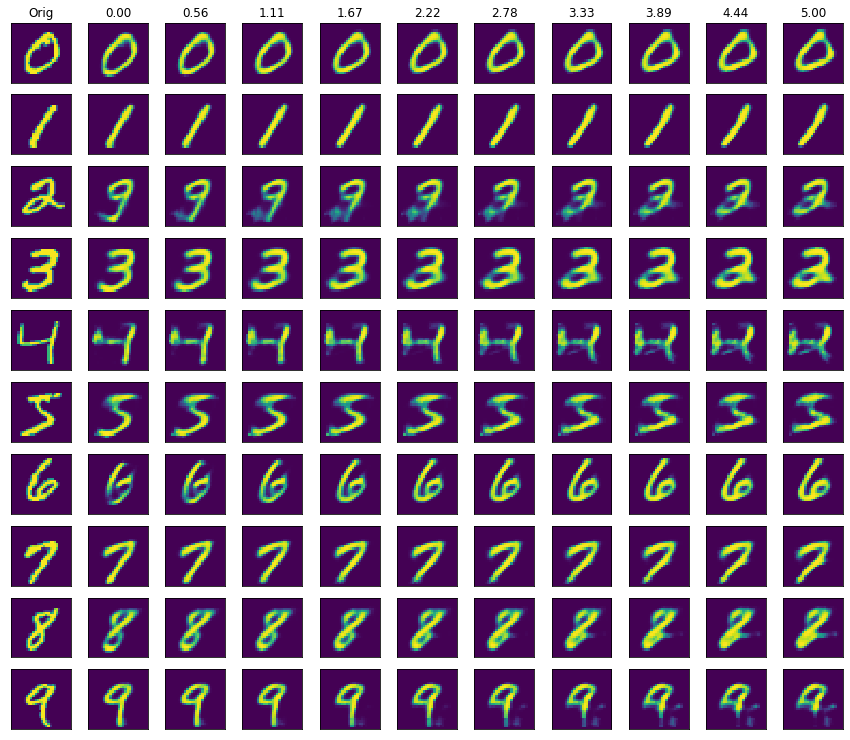

Sweeping reconstructions over latent variable no. 1


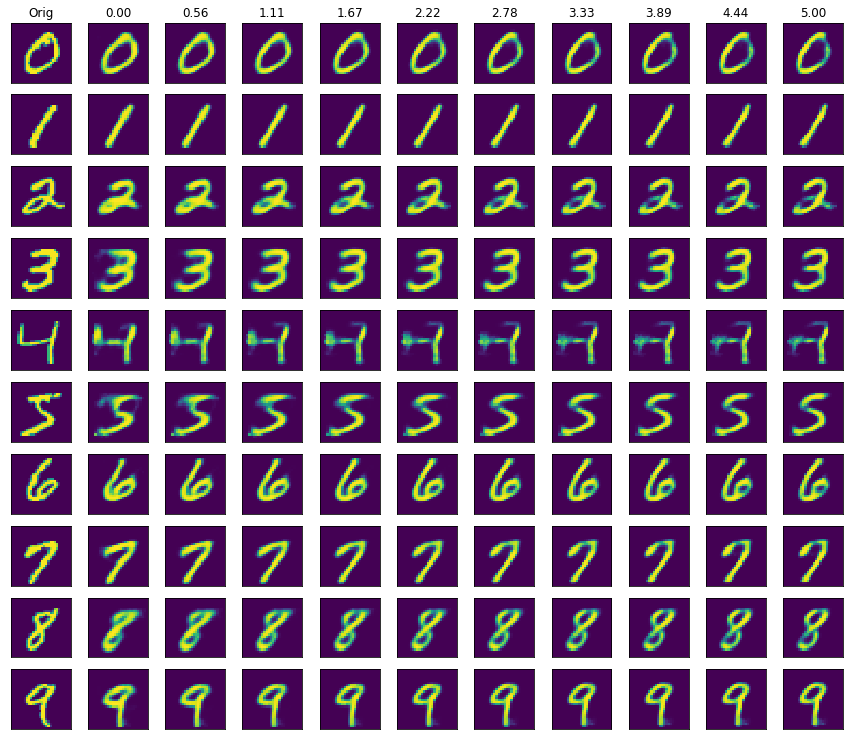

Sweeping reconstructions over latent variable no. 2


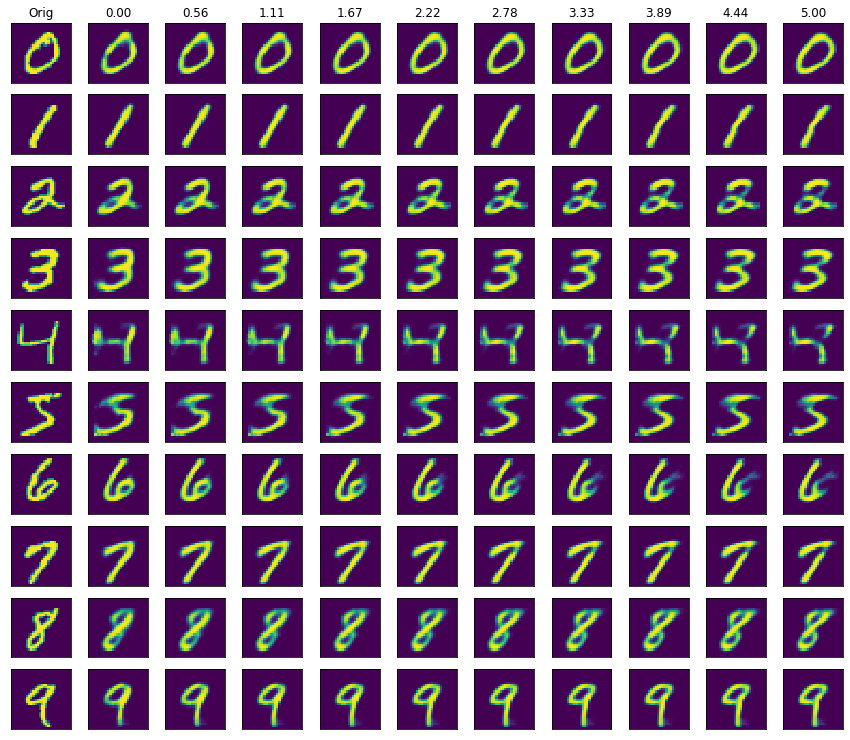

Sweeping reconstructions over latent variable no. 3


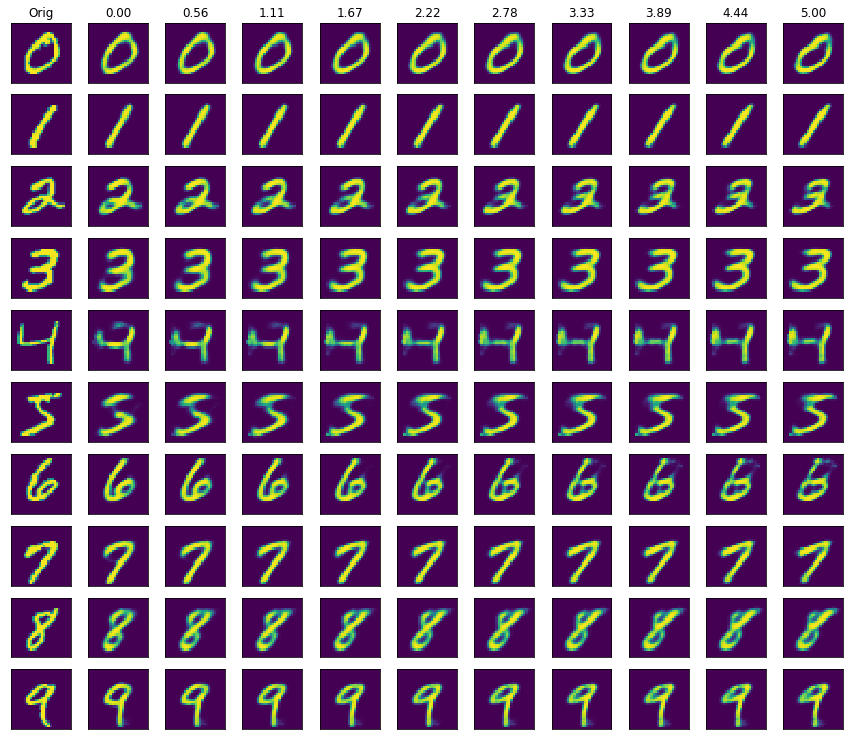

Sweeping reconstructions over latent variable no. 4


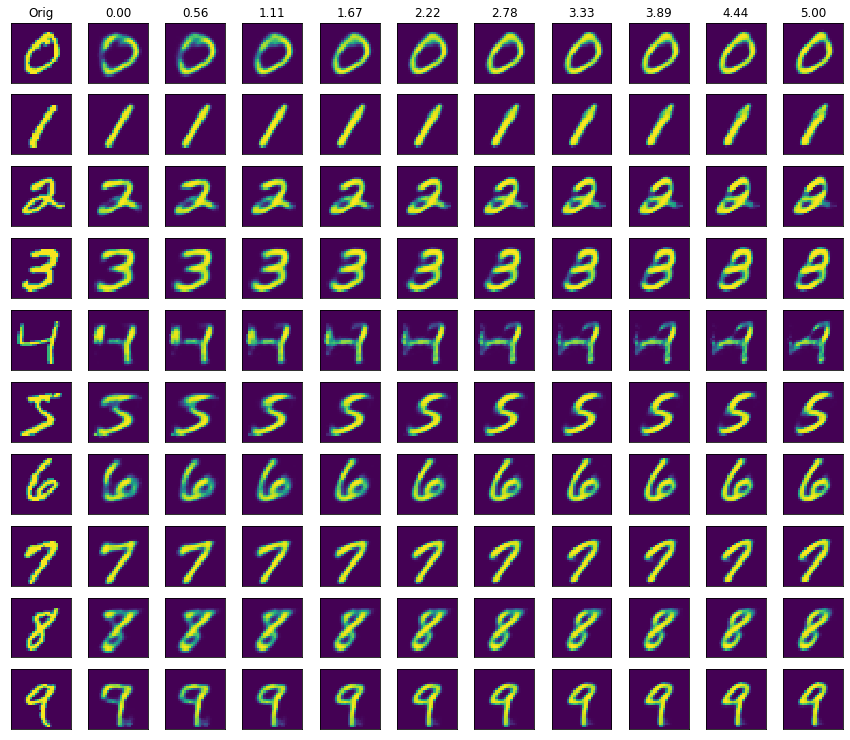

Sweeping reconstructions over latent variable no. 5


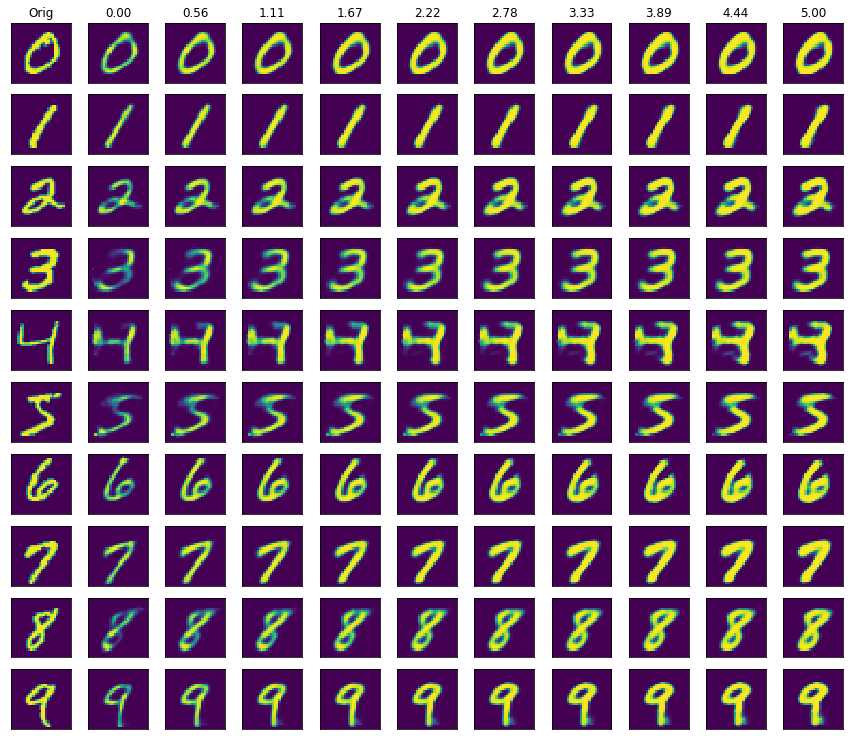

Sweeping reconstructions over latent variable no. 6


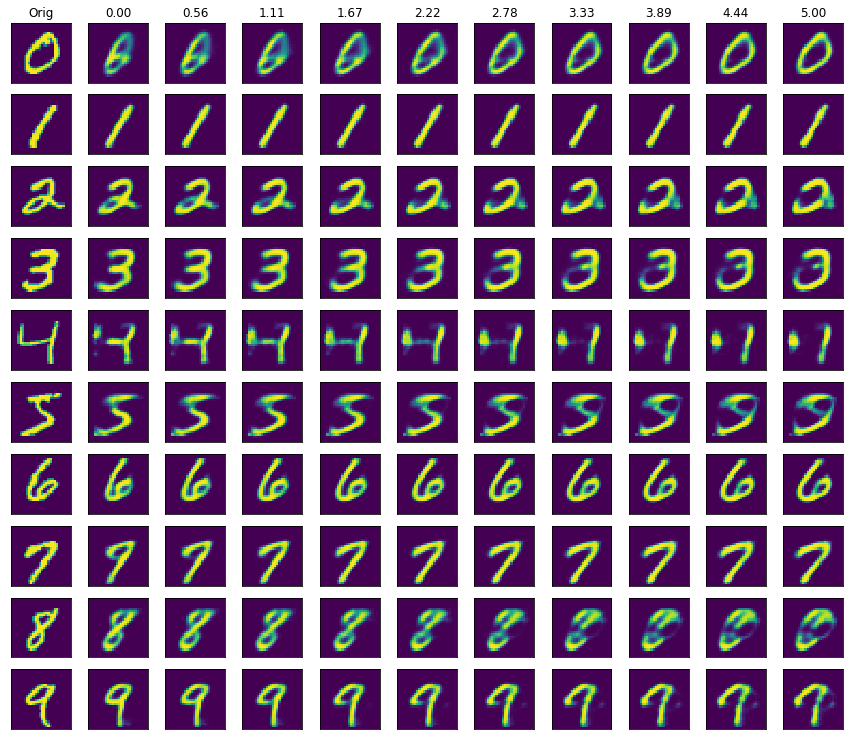

Sweeping reconstructions over latent variable no. 7


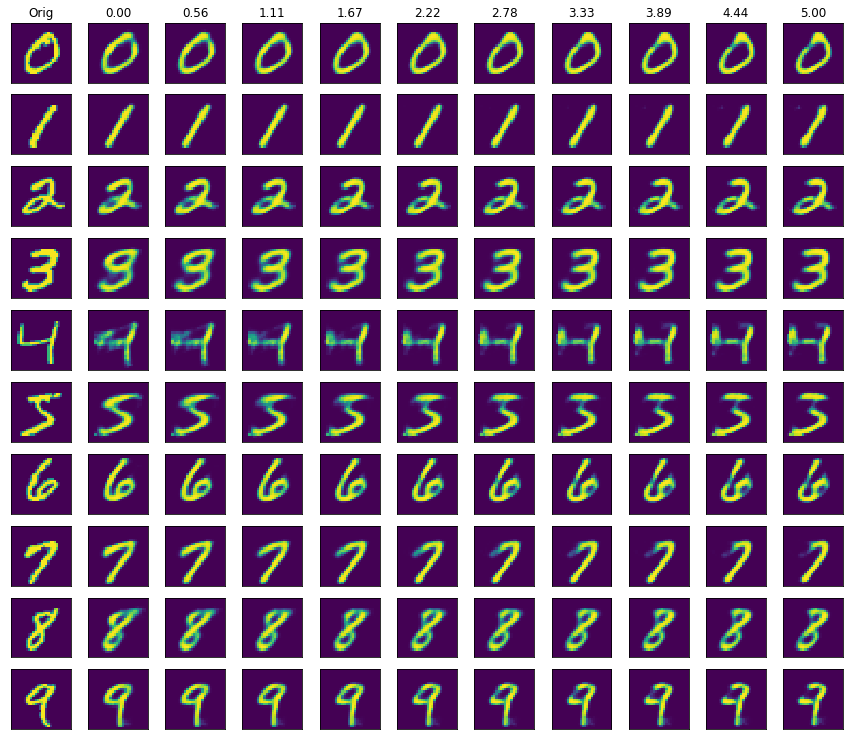

Sweeping reconstructions over latent variable no. 8


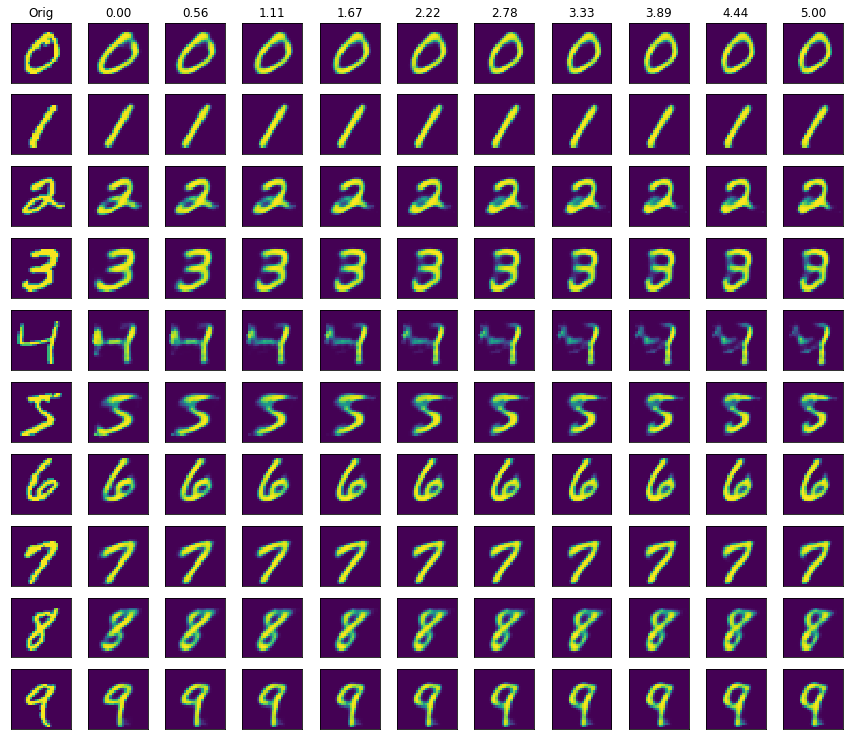

Sweeping reconstructions over latent variable no. 9


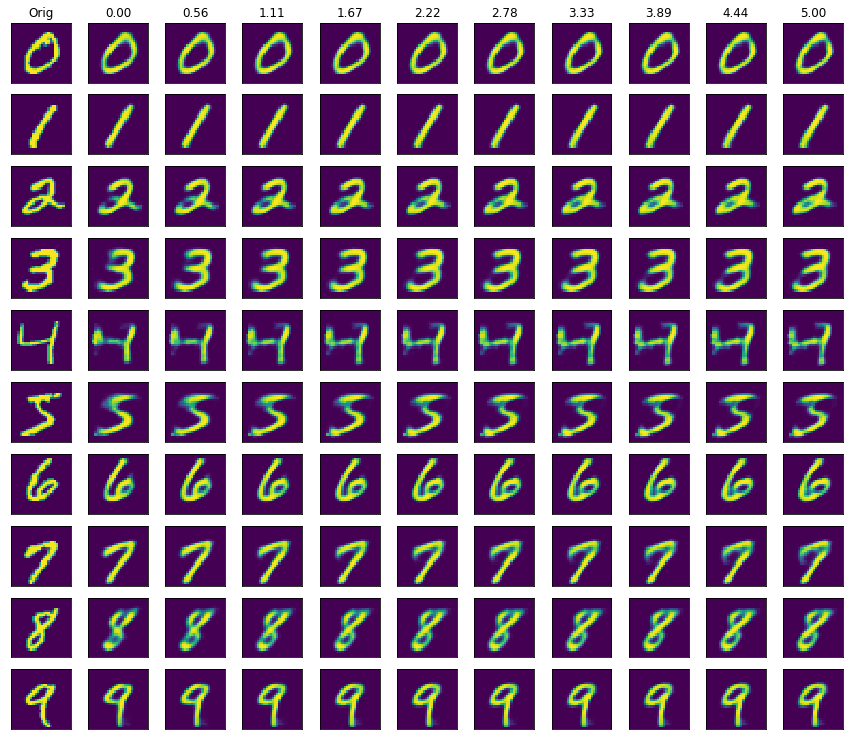

Sweeping reconstructions over latent variable no. 10


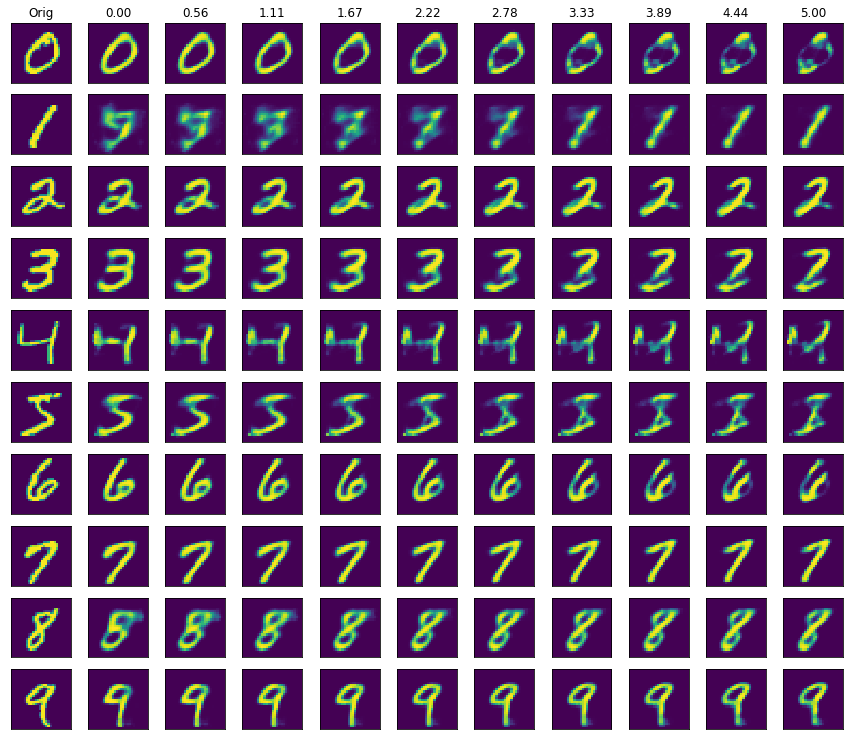

Sweeping reconstructions over latent variable no. 11


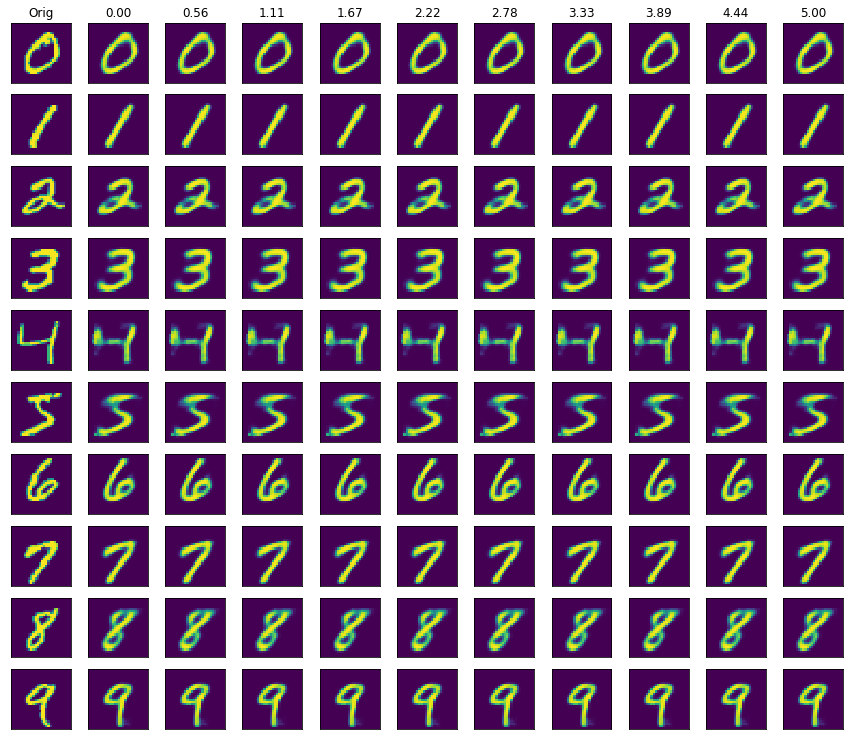

Sweeping reconstructions over latent variable no. 12


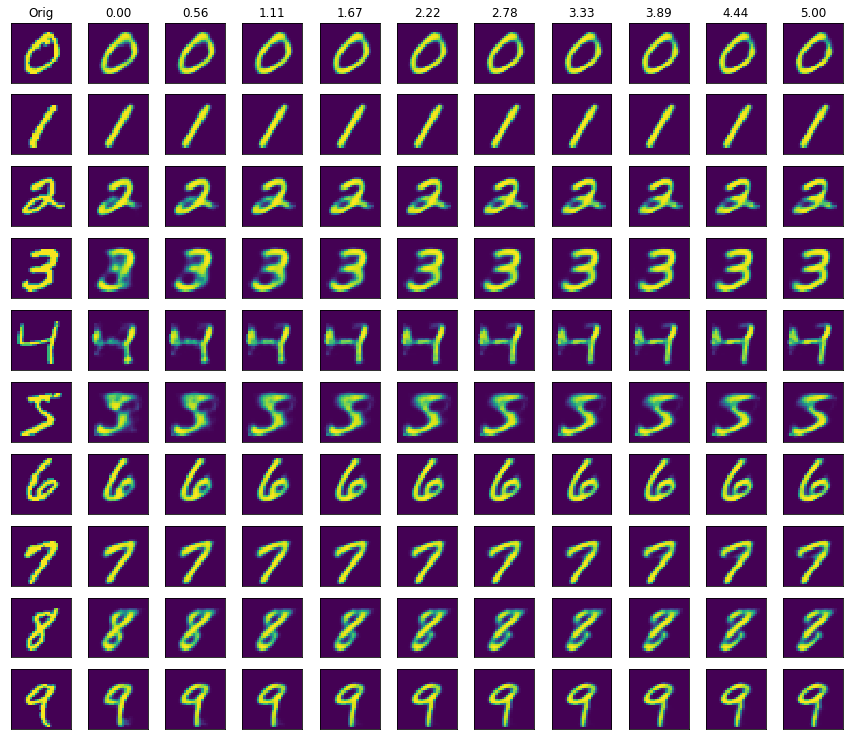

Sweeping reconstructions over latent variable no. 13


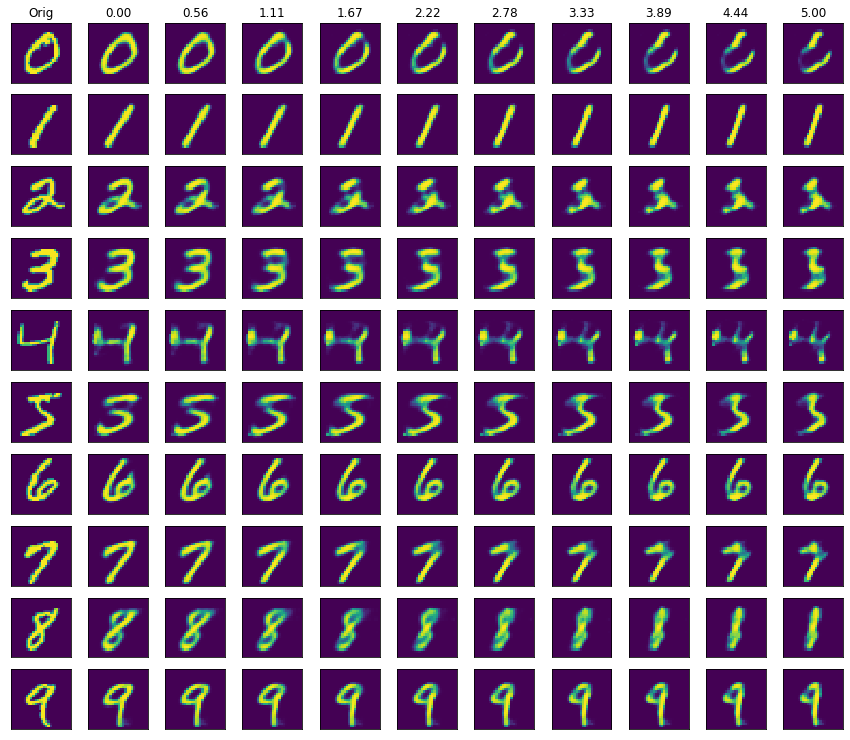

Sweeping reconstructions over latent variable no. 14


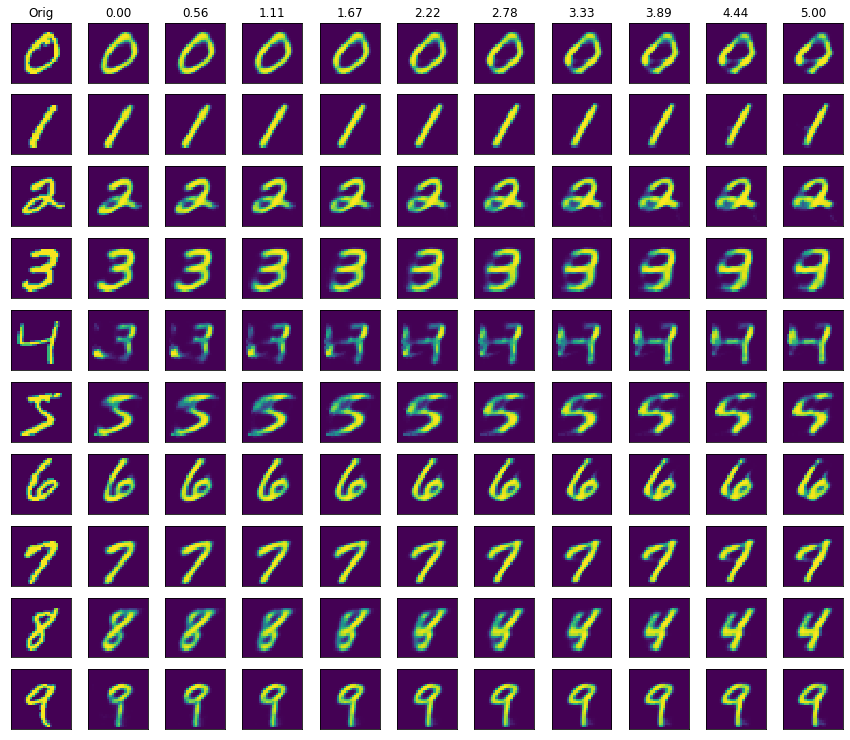

Sweeping reconstructions over latent variable no. 15


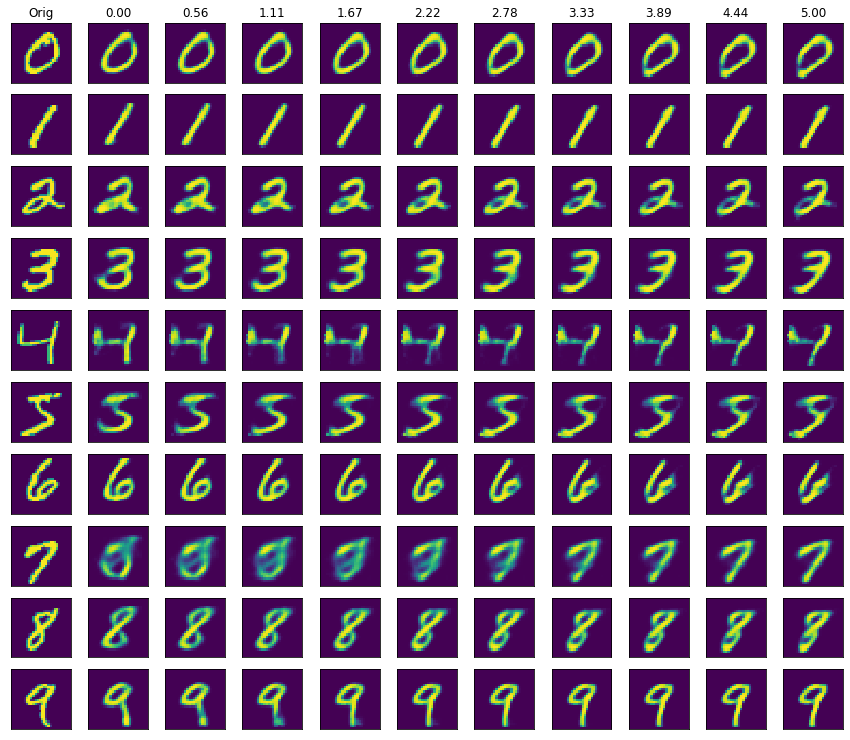

Sweeping reconstructions over latent variable no. 16


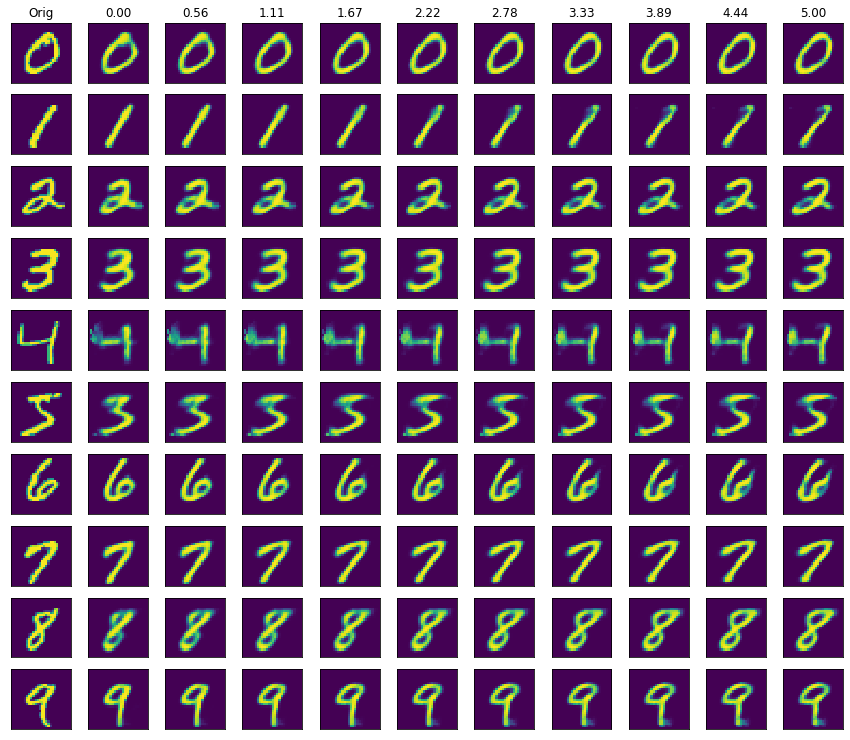

Sweeping reconstructions over latent variable no. 17


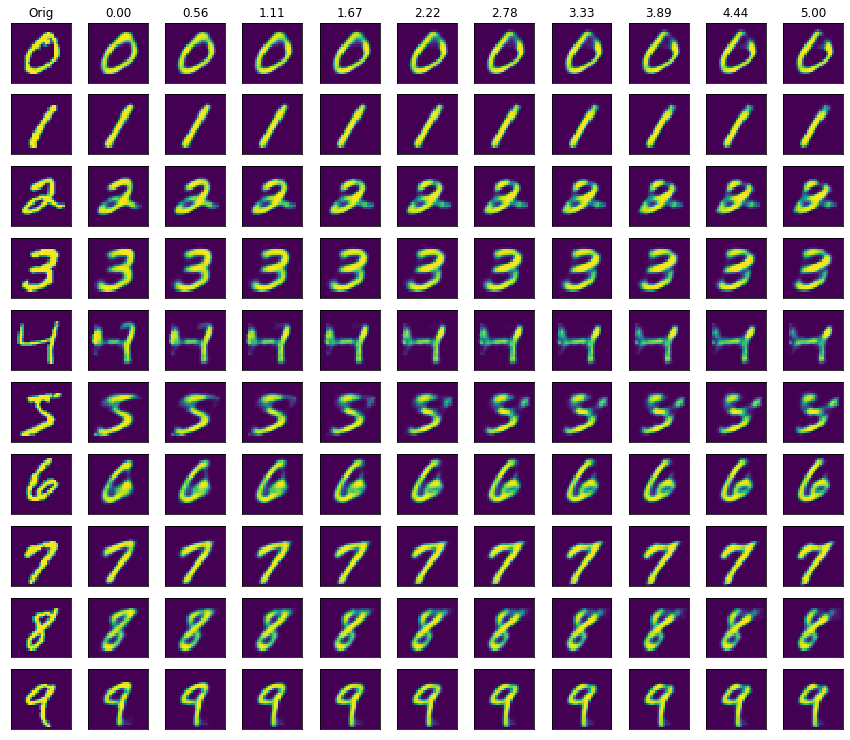

Sweeping reconstructions over latent variable no. 18


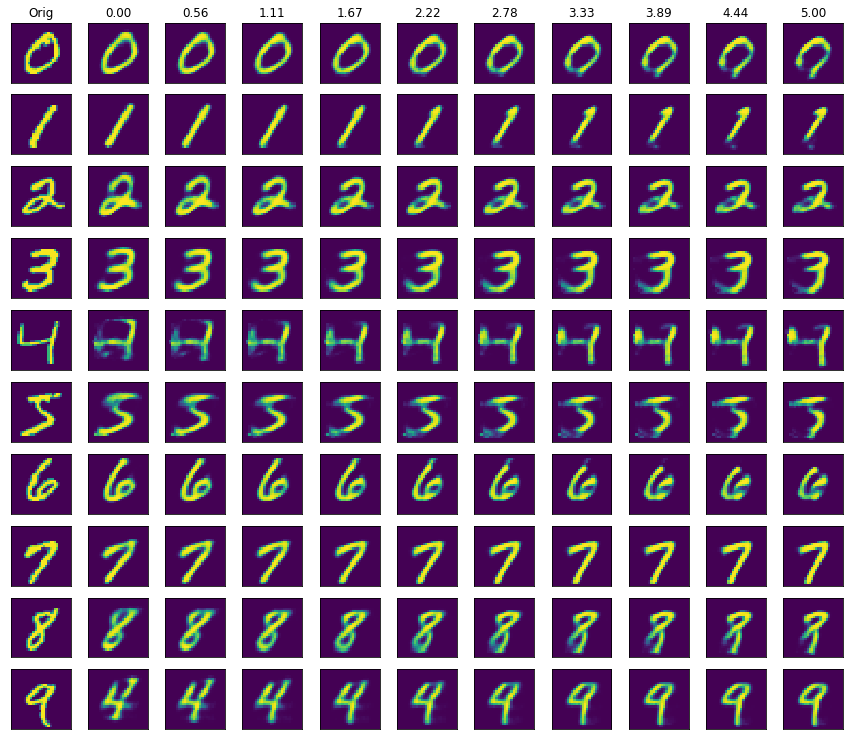

Sweeping reconstructions over latent variable no. 19


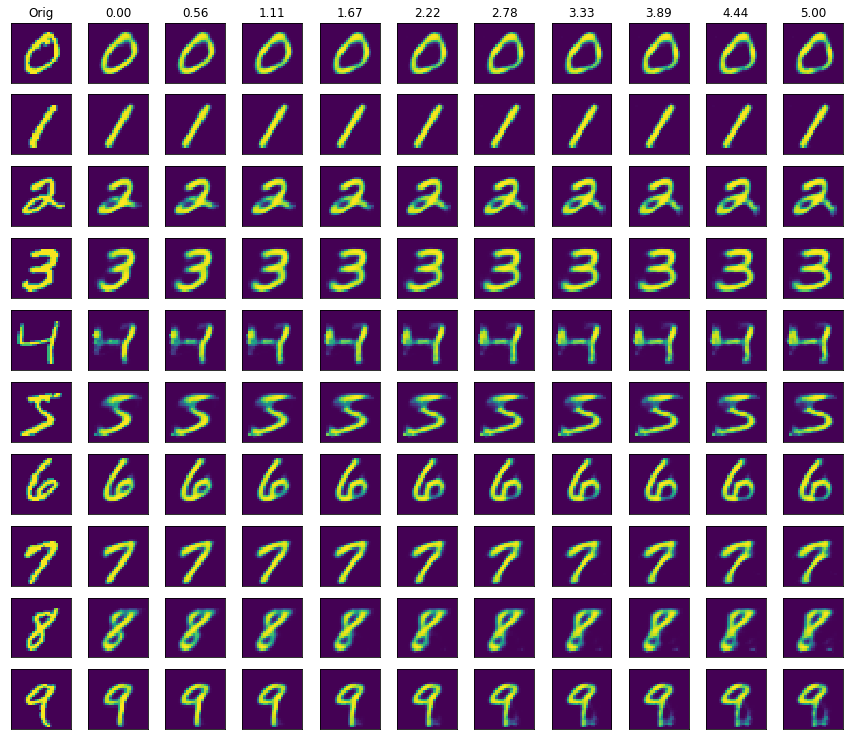

In [11]:
for i in range(20):
    print(f'Sweeping reconstructions over latent variable no. {i}')
    enc = digit_encodings.clone()
    recons_by_var = sweep_variable_across_samples(net.module_, enc, i, sweep_range)
    plot_sweep_grid(digits, recons_by_var, sweep_range)

In [12]:
df = pd.DataFrame(digit_encodings.numpy())

In [13]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.076734,0.605867,1.257338,0.632972,4.295095,0.547351,7.087420,1.168932,1.538076,1.857248,0.760035,2.780274,0.548770,0.696741,0.289405,1.602824,0.830038,0.496055,0.429295,0.486618
1,0.657392,0.440379,0.732983,1.315192,0.321808,0.727431,0.825307,0.992299,0.745874,0.174185,10.490700,4.700007,1.180850,0.511330,0.821584,2.228682,0.333459,1.260112,0.616379,0.340741
2,8.690322,2.281309,0.470588,1.046045,1.814244,1.078768,0.312690,0.618633,0.407286,1.251989,0.733624,3.452336,1.537617,0.125051,0.177011,2.755130,2.062486,0.260674,2.436329,0.963695
3,0.453044,1.553037,0.654917,1.222349,0.979855,3.025208,0.851797,3.586352,0.296733,1.473338,0.780820,0.993692,3.640110,0.147567,0.520241,1.450094,2.579626,0.593273,0.553361,1.214437
4,1.268639,0.405727,0.239110,4.095148,1.146434,0.105476,1.291575,3.618435,0.347445,0.512121,0.912620,2.279426,1.493131,0.308536,5.285724,0.361322,5.744598,0.772595,2.780375,2.274100
5,1.061647,1.105038,2.478113,1.931196,0.415456,1.687906,1.384490,1.075850,0.196585,0.944724,0.454494,0.686916,7.388263,1.778454,0.080324,1.706883,2.529238,0.037792,0.535150,0.605488
6,3.537479,3.050237,0.158050,0.783376,4.992690,0.946390,1.248702,0.977338,0.849023,0.899283,1.042664,4.055780,1.904682,0.743281,0.851334,1.423057,1.241730,7.379602,0.580188,0.500177
7,0.490783,0.728448,0.765193,1.970847,1.371526,0.793534,1.985506,0.294396,1.145421,0.292350,1.096817,0.333205,0.707908,0.430930,1.229402,8.581965,0.834082,0.399874,1.185811,0.736557
8,0.707453,1.265818,3.495331,0.929311,2.044066,1.482356,0.141812,0.926154,0.518577,3.675314,3.151556,1.243801,0.632700,0.257385,0.091951,2.617988,0.966055,1.404887,0.534664,0.327070
9,0.970030,2.273516,3.345844,0.674757,2.343762,0.895908,0.553347,0.742371,0.161881,0.902510,1.917412,0.770655,0.467799,0.710352,4.037809,2.097013,1.290963,2.128733,6.004978,1.604991


In [14]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.891352,1.370938,1.359747,1.460119,1.972493,1.129033,1.568264,1.400076,0.620690,1.198306,2.134074,2.129609,1.950183,0.570963,1.338479,2.482496,1.841227,1.473360,1.565653,0.905387
std,2.549051,0.905175,1.269302,1.039008,1.558563,0.801579,2.015336,1.187660,0.448540,1.012694,3.040029,1.554300,2.130259,0.482061,1.814735,2.250242,1.564970,2.167127,1.776348,0.630081
min,0.453044,0.405727,0.158050,0.632972,0.321808,0.105476,0.141812,0.294396,0.161881,0.174185,0.454494,0.333205,0.467799,0.125051,0.080324,0.361322,0.333459,0.037792,0.429295,0.327070
25%,0.669907,0.636512,0.516670,0.819860,1.021500,0.743957,0.621337,0.788317,0.309411,0.608912,0.765231,0.826415,0.651502,0.270173,0.205110,1.488276,0.867075,0.423919,0.539703,0.490007
50%,1.015839,1.185428,0.749088,1.134197,1.592885,0.921149,1.050250,0.984819,0.462932,0.923617,0.977642,1.761614,1.336991,0.471130,0.670913,1.901948,1.266346,0.682934,0.598283,0.671023
75%,1.220663,2.093396,2.172919,1.777195,2.268838,1.381459,1.361261,1.145661,0.823235,1.418001,1.712263,3.284321,1.812916,0.706949,1.134885,2.520661,2.412550,1.368693,2.123700,1.151751
max,8.690322,3.050237,3.495331,4.095148,4.992690,3.025208,7.087420,3.618435,1.538076,3.675314,10.490700,4.700007,7.388263,1.778454,5.285724,8.581965,5.744598,7.379602,6.004978,2.274100


# Infer Latent Variable Dists

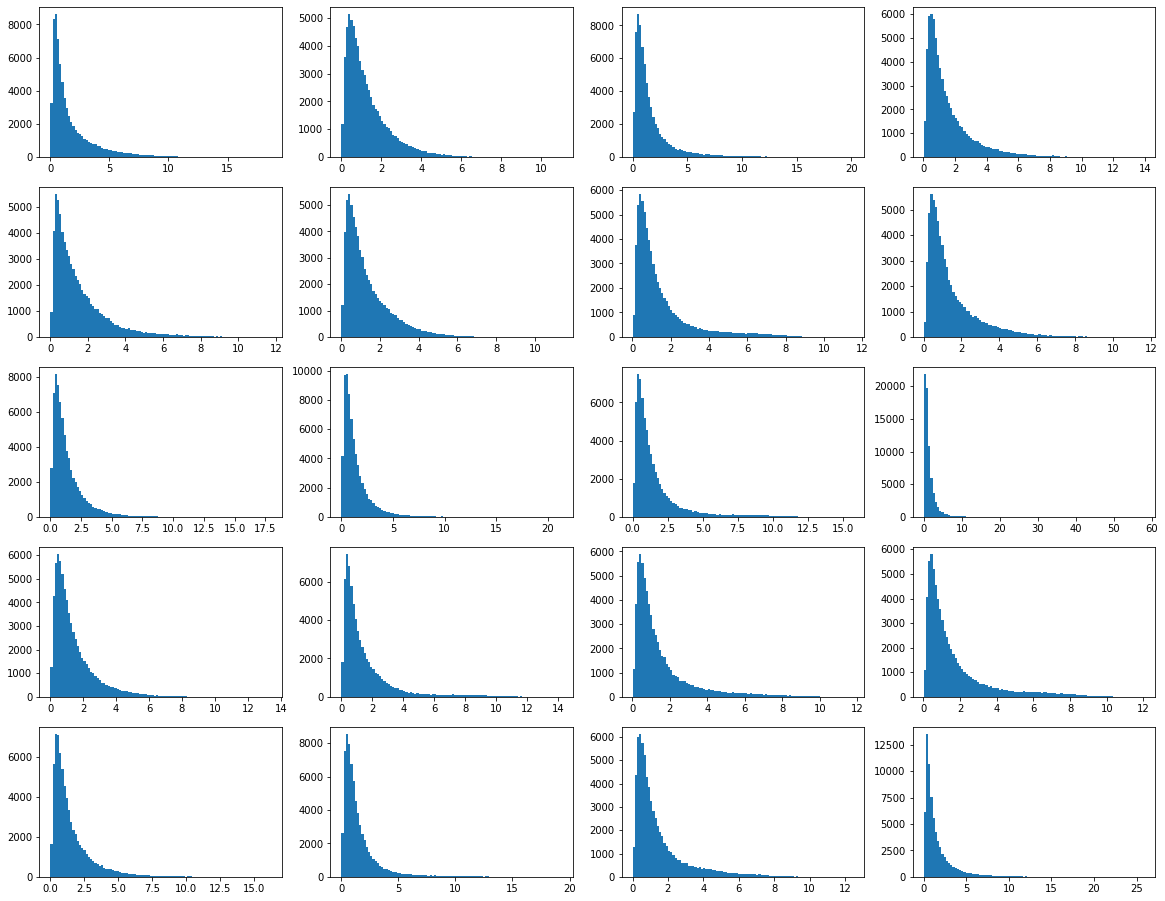

In [15]:
vae = net.module_
enc = vae.reparameterize(*vae.encode(torch.tensor(X)))
enc = enc.detach().numpy()
plt.figure(figsize=(20, 16))
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.hist(enc[:, i], bins=100)
plt.show()

In [16]:
def infer_encoding_dists(X, vae, bins=100):
    enc = vae.reparameterize(*vae.encode(torch.tensor(X)))
    enc = enc.detach().numpy()
    plt.figure(figsize=(12, 12))
    for i in range(20):
        ys, xs = np.histogram(enc[:, i], bins=bins)
        plt.plot(xs[:-1], ys)
        plt.xlim([-1, 10])
    plt.show()

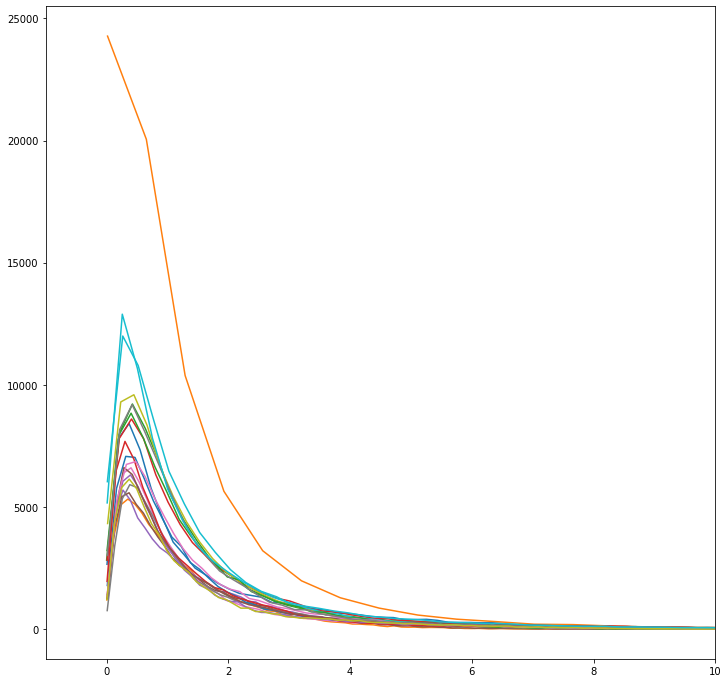

In [17]:
infer_encoding_dists(X, net.module_)